![NCAR UCAR Logo](../NCAR_CISL_NSF_banner.jpeg)
# Using Dask with GPUs via CuPy and introducing cuDF
**NCAR GPU Workshop  
August 11th 2022**

**Presenter:**  
Brian Vanderwende  
[vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)  
Consulting Services Group

## Obtaining this notebook
Follow these steps to create a clone of this repo. If you have already done so in a prior session, simply run a pull operation to obtain the materials for this week.

| JupyterLab | Terminal |
|-|-|
| Use the JupyterHub GitHub GUI on the left</br>panel or the below shell commands | `git clone git@github.com:NCAR/GPU_workshop.git`</br>`git pull` |

Once cloned or updated, navigate to `GPU_workshop/13_DaskGPU` in the repo and open this notebook.

*For this session, we do not have the resources allocated for attendees to follow along during the live presentation, as we will demonstrate scaling and memory effects and thus need to use V100s. Instructions are provided at the end of this notebook for running it independently after the presentation.*

## Workshop Etiquette
* Please mute yourself and turn off video during the session.
* Questions may be submitted in the chat and will be answered when appropriate. You may also raise your hand, unmute, and ask questions during Q&A at the end of the presentation.
* By participating, you are agreeing to [UCAR’s Code of Conduct](https://www.ucar.edu/who-we-are/ethics-integrity/codes-conduct/participants)
* Recordings & other material will be archived & shared publicly.
* Feel free to follow up with the GPU workshop team via Slack or submit support requests to [support.ucar.edu](https://support.ucar.edu)
    * Office Hours: Asynchronous support via [Slack](https://ncargpuusers.slack.com) or schedule a time with an organizer

---

## Recall from last session...

We explored the **CuPy** package, which provides a GPU drop-in replacement for *most* **Numpy** functionality ([comparison table](https://docs.cupy.dev/en/stable/reference/comparison.html)).

### **CuPy**: creating arrays of data

In [1]:
import numpy as np
import cupy as cp

Creating a random Gaussian array on the CPU with Numpy ...

In [2]:
cpu_arr = np.random.randn(10_000, 10_000)
print(f'Mem used: {cpu_arr.nbytes / 1024**2:.2f} MiB')

Mem used: 762.94 MiB


And creating the same array on the GPU ...

In [3]:
gpu_arr = cp.random.randn(10_000, 10_000)
print(f'Mem used: {gpu_arr.nbytes / 1024**2:.2f} MiB')

Mem used: 762.94 MiB


#### Comparing the speed of `.mean()`

In [4]:
%%time
cpu_arr.mean()

CPU times: user 65.6 ms, sys: 1.2 ms, total: 66.8 ms
Wall time: 65.8 ms


0.00010802916697213106

In [6]:
%%time
gpu_arr.mean()

CPU times: user 411 µs, sys: 146 µs, total: 557 µs
Wall time: 451 µs


array(-2.11241951e-05)

#### Checking GPU results for correctness

In [7]:
%%time
gpu_copy = cp.array(cpu_arr)

CPU times: user 154 ms, sys: 398 ms, total: 552 ms
Wall time: 551 ms


In [8]:
%%time
gpu_copy.mean()

CPU times: user 340 µs, sys: 181 µs, total: 521 µs
Wall time: 390 µs


array(0.00010803)

#### Analyzing CuPy's memory pool

Once GPU memory is allocated to an object, CuPy will expand it's *memory pool* by at least that amount. When an object is deallocated, the memory pool will hold on to that space in memory for faster subsequent operations.

In [9]:
mempool = cp.get_default_memory_pool()

In [10]:
def cupy_mem_stats():
    print(f'GPU: used memory = {mempool.used_bytes() / 1024**2:.2f} MiB')
    print(f'GPU: total pool  = {mempool.total_bytes() / 1024**2:.2f} MiB')

In [11]:
cupy_mem_stats()

GPU: used memory = 1525.88 MiB
GPU: total pool  = 1525.88 MiB


Let's release our data for garbage collection. This will free up space in CuPy's memory pool on the GPU.

In [12]:
del cpu_arr, gpu_arr, gpu_copy

In [13]:
cupy_mem_stats()

GPU: used memory = 0.00 MiB
GPU: total pool  = 1525.88 MiB


We can also explicitly release all GPU memory from CuPy's pool. This step can be useful if utilizing other GPU libraries in your workflow.

In [14]:
mempool.free_all_blocks()

In [15]:
cupy_mem_stats()

GPU: used memory = 0.00 MiB
GPU: total pool  = 0.00 MiB


#### Let's track performance and memory usage for something bigger ...

Rather than load a big data file, we will use the following function to produce a facimile temperature dataset. Feel free to play with the array size but be aware of the memory footprint!

In [16]:
def aqua_gen(nx, ny, nt):
    """Takes dimensions nx, ny, nt and returns an ndarray with facimile dataset."""
    
    t = np.random.random((nx, ny, nt))
    t = t + np.linspace(287, 289, nt)
    t = t + np.sin(np.linspace(0.0, np.pi * nt, nt))
    t = t + (np.sin(np.linspace(0.0, np.pi, ny)) * 20 - 10)[None,:,None]
    
    return t

First, we will use the function to create a NumPy array of decent size

In [17]:
t = aqua_gen(4000, 2000, 140)
print(f'Size: {t.nbytes / 1024**3:.2f} GiB')

Size: 8.34 GiB


We've produced a dataset that looks something like surface temperatures across an aquaplanet. (*at least one without weather!*)

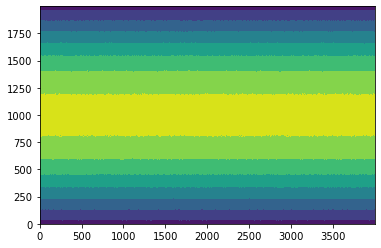

In [18]:
import matplotlib.pyplot as plt
plt.contourf(t[:,:,0].transpose())

Now we can copy it to the GPU and track what happens with the memory usage and pool

In [19]:
cupy_mem_stats()
tg = cp.asarray(t)
cupy_mem_stats()

GPU: used memory = 0.00 MiB
GPU: total pool  = 0.00 MiB
GPU: used memory = 8544.92 MiB
GPU: total pool  = 8544.92 MiB


Finally, let's compare the performance of an operation to convert to Celsius and take the time-mean at each grid point

In [20]:
%time cpu_tm = np.mean((t - 273.15), axis = 2)

CPU times: user 1.78 s, sys: 1.74 s, total: 3.51 s
Wall time: 3.51 s


In [22]:
%time gpu_tm = cp.mean((tg - 273.15), axis = 2)
cupy_mem_stats()

CPU times: user 1.06 ms, sys: 52 µs, total: 1.11 ms
Wall time: 710 µs
GPU: used memory = 8605.96 MiB
GPU: total pool  = 17211.92 MiB


In [23]:
del cpu_tm, gpu_tm, tg
mempool.free_all_blocks()
cupy_mem_stats()

GPU: used memory = 0.00 MiB
GPU: total pool  = 0.00 MiB


**GPU memory is smaller than node memory - if we need to process very large arrays of data, we will need a tool to parallelize across multiple GPUs ...**

---

## Using Dask with GPUs

Dask is a popular Python library for parallelizing computations across multiple workers. It provides incredibly easily scaling of code from problem sizes that fit on a dual-core laptop to those that can span an entire analysis cluster like Casper.

* Dask is easy to install
* Dask leverages high-level collections like NumPy arrays and pandas DataFrames
* Dask can schedule workers itself or submit jobs to batch schedulers like PBS and Slurm
* Dask workers can use GPUs

**Dask allows you to scale up from problem sizes that fit in node *or GPU* memory to ones that fit on disk.**

### Dask fundamentals and how the GPU is supported

Dask operates on either a high-level collection of data like an array, Series, or DataFrame, or a low-level collection of arbitrary code marked for either `delayed` or asynchronous (`futures`) parallel execution. In this tutorial, we will focus on high-level data structures.

| Dask collection | CPU object | GPU object | GPUs |
|-|-|-|-|
| dask.array | numpy.array | cupy.array | NVIDIA, AMD |
| dask.series | pandas.series | cudf.series | NVIDIA |
| dask.dataframe | pandas.dataframe | cudf.dataframe | NVIDIA |

Most Dask operations use *lazy evaluation*, meaning you tell Dask what you want the workers to do, but then they wait until you start the computation using `.compute()` (or similar methods). These instructions are collectively called a *task graph*, and then map out what Dask will do to get from your data collection to your desired output. Notably, worker memory is not consumed until you begin executing the task graph.  
</br>
<div style="text-align:center;"><img src=images/dask-overview.svg width=800px alt="Dask Flow"></img></br><i>Image credit: Anaconda, Inc. and contributors</i></div>  
</br>  

**Fundamentally, nothing about this workflow is different when using GPUs.**

#### When might you use Dask with GPUs?

While Dask is easy to use, even the simplest of parallel computing approaches can be tricky to get right. Here are some scenarios where scaling GPU resources with Dask can be powerful:

1. You are lucky enough to have many GPU resources with low contention and can be bursty
2. Your workflow benefits tremendously from GPU acceleration, but is too big for a single GPU
3. A small segment of your analysis workflow can benefit from on-demand access of GPUs
4. You are running a large application with MPI and wish to do between-cycle data work

#### Notable Dask packages

Dask functions are broken into a diverse ecosystem of packages. Here is a list of notables for GPU usage:

* **dask** - the core API, including collections and a basic task scheduler
* **distributed** - cluster objects (groups of workers) that can span a network and detailed dashboards
* **dask-jobqueue** - Dask HPC clusters (e.g., `PBSCluster`, `SLURMCluster`)
* **dask-cuda** - tools to set up GPU-backed workers (especially on single nodes)
* **dask-mpi** - construct clusters of workers using MPI processes (*can be used with dask-cuda*)

### Using NVIDIA's LocalCUDACluster

The `LocalCUDACluster` cluster object comes from the **dask-cuda** package. It isn't required to use **CuPy** and **cuDF** collections with Dask, but it eases pinning local GPUs to specific workers and provides functionality for GPU memory spilling and high-speed worker communication via UCX. It is developed as part of RAPIDS.  

*UCX requires [compilation and customization](https://docs.rapids.ai/api/dask-cuda/stable/ucx.html) so we will avoid here for the sake of simplicity.*

#### First, we need to start our cluster...

The **dask-cuda** [API document](https://docs.rapids.ai/api/dask-cuda/stable/api.html#cluster) is useful here for cluster settings.

In [24]:
import dask.array as da
from dask.distributed import Client
from dask_cuda import LocalCUDACluster

By default, it would spawn `len(CUDA_VISIBLE_DEVICES)` workers.  

We will also associate our cluster object with a `Client`. The client is our runtime interface to the cluster and Dask scheduler.

In [25]:
cluster = LocalCUDACluster()
client = Client(cluster, timeout = '60s')

2022-08-11 10:29:39,195 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2022-08-11 10:29:39,232 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
Unable to start CUDA Context
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/pygpu-dask/lib/python3.9/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/glade/u/apps/opt/conda/envs/pygpu-dask/lib/python3.9/site-packages/distributed/comm/ucx.py", line 104, in init_once
    cuda_visible_device = int(
ValueError: invalid literal for int() with base 10: 'GPU-30104623-af2a-4c39-2a28-07ff7b90b70e'
Unable to start CUDA Context
Traceback (most recent call last):
  File "/glade/u/apps/opt/conda/envs/pygpu-dask/lib/python3.9/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/glade/u/apps/opt/conda/envs/pygpu-dask/lib/python3.9/site-packag

*Did it work?*

If you are using multiple GPUs, the `CUDA_VISIBLE_DEVICES` environment variable needs to be set to integer device IDs, not string GPU UUIDs as PBS specifies.

First, let's shut down our prior attempt to free the port for a new cluster and client.

In [26]:
client.shutdown()

#### Querying GPU information with **pynvml**

The **pynvml** provides Python bindings to the NVIDIA Management Library (NVML), which allows users to query and (often with root) modify GPU characteristics and behavior. We can import and use it to get information about our GPUs from within Python.

In [27]:
from pynvml import *
nvmlInit()

In [28]:
cmode_names = ['Default', 'Exclusive Thread', 'Prohibited', 'Exclusive Process']

for i in range(nvmlDeviceGetCount()):
    handle = nvmlDeviceGetHandleByIndex(i)
    uuid = nvmlDeviceGetUUID(handle).decode("utf-8")
    cmode = nvmlDeviceGetComputeMode(handle)
    print(f'Device {i} UUID: {uuid}; Compute mode: {cmode_names[cmode]}')

Device 0 UUID: GPU-30104623-af2a-4c39-2a28-07ff7b90b70e; Compute mode: Default
Device 1 UUID: GPU-ff46f738-51a2-cfd7-2163-45524f96ac82; Compute mode: Default


**Heads up:** You are likely to run into issues in Python if you use a GPU that is not using the Default compute mode. Exclusive process mode, for example, will prevent you from using **CuPy** and a **CUDAWorker** in the same Python process!
```
Device 0 UUID: GPU-c0bdd08e-994c-f92d-6ad7-7b629156e76d; Compute mode: Exclusive Process
Device 1 UUID: GPU-e8571304-3a7b-443e-d688-933be18cfbeb; Compute mode: Default
```
If you see something like the above, make sure to change (or more likely have your sys admin change) the compute mode to default either in Python or using `nvidia-smi`:
```bash
sudo nvidia-smi -c 0 -i UUID
```
#### Let's put CUDA_VISIBLE_DEVICES in a form (device IDs) that `LocalCUDACluster` will accept

In [29]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [30]:
cluster = LocalCUDACluster()
client = Client(cluster, timeout = '60s')

2022-08-11 10:34:21,358 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2022-08-11 10:34:21,447 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [31]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43624,Workers: 2
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:40331,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/44079/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:38616,


**Now we are ready to scale up computations with Dask!**  

We can use our aquaplanet temperature array we created earlier. Let's imagine that the array is a single output file, and we need to process twelve of them.

#### Construct a Dask Array *on the GPU* using the NumPy array we created ...

First we use the NumPy array to define our chunk size - the number of elements for each chunk of work to be done by a worker.

In [32]:
dc_arr = da.from_array(t, chunks = (1000, 500, 140))

To create a Dask Array on the GPU, we simply need to map a conversion from NumPy to CuPy to all of our data chunks.

In [33]:
dg_arr = dc_arr.map_blocks(cp.asarray)

We can now concatenate multiple copies of this dask array together to form our "multifile" dataset

In [34]:
dg_mf = da.concatenate([dg_arr] * 12, axis=2)
dg_mf

dask.array<concatenate, shape=(4000, 2000, 1680), dtype=float64, chunksize=(1000, 500, 140), chunktype=cupy.ndarray>

#### Assigning tasks to a Dask collection

Let's do some data processing on our GPU Dask Array. We can convert from Kelvin to Celsius and then take the mean across all times at each spatial index.

In [35]:
tg = da.mean((dg_mf - 273.15), axis = 2)

In [36]:
tg.dask

HighLevelGraph with 7 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x2afc9e63e820>
 0. array-2d6d607525c93a60d3ebad8394f5ac20
 1. asarray-0bb0329305b0a5ad59d3ae1aa871cf9b
 2. concatenate-24ceb3de61d0b0ff573788d6cb562fe3
 3. sub-093fe9c8396bd9974170f9e9861562cf
 4. mean_chunk-531ead781e91c7fa6a7e1202e6f60623
 5. mean_combine-partial-755fbbc74e3e8418a15be3fa795b0520
 6. mean_agg-aggregate-6271223e55f4c885b20b0e134ec94962

Using the above attribute, we can see the tasks that Dask will run, but remember, it does not actually perform any computation (*or even map our CPU array into GPU memory*) until we run `.compute()`.

In [37]:
%%time
dg_means = tg.compute()

CPU times: user 2.63 s, sys: 9.96 s, total: 12.6 s
Wall time: 18.1 s


In [38]:
del dg_means

In [39]:
client.shutdown()

In [40]:
del client, cluster

### Scheduling GPUs with `dask-jobqueue`

In this workflow, we use a scheduler cluster object like `PBSCluster` to submit batch jobs to run single workers. This cluster is often easier to augment with GPUs, as we only need to make a few tweaks to our worker resource specification and GPU pinning to each worker is done implicitly through job GPU assignment.

#### Consider the following distributed CPU code

```python
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores=1,
    memory='35GiB',
    processes=1,
    resource_spec='select=1:ncpus=1:mem=35GB',
    queue='casper',
    walltime='10:00',
    interface='ib0'
)
```

#### Let's modify it to create GPU workers from dask_jobqueue import PBSCluster

In [41]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores=1,
    memory='35GiB',
    processes=1,
    resource_spec='select=1:ncpus=1:mem=35GB:ngpus=1',
    job_extra=['-l gpu_type=a100'],
    queue='preview',
    walltime='10:00',
    interface='ib0'
)

In [42]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q preview
#PBS -A SCSG0001
#PBS -l select=1:ncpus=1:mem=35GB:ngpus=1
#PBS -l walltime=10:00
#PBS -e dask-worker-logs/
#PBS -o dask-worker-logs/
#PBS -l gpu_type=a100

/glade/u/apps/opt/conda/envs/pygpu-dask/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:34094 --nthreads 1 --memory-limit 35.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask --interface ib0



In [43]:
client = Client(cluster, timeout = '60s')
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:34094,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/vanderwb/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [44]:
cluster.scale(2)
client.wait_for_workers(2)

In [45]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
3810280.casper* vanderwb R3786268 STDIN        8809   1   2  100gb 01:30 R 00:54
3811912.casper* vanderwb asdgpu   dask-work* 283440   1   1   35gb 00:10 R 00:00
3811913.casper* vanderwb asdgpu   dask-work* 219531   1   1   35gb 00:10 R 00:00

Cached at: Thu Aug 11 10:44:26 MDT 2022


In [46]:
%%time
dg_means = tg.compute()

CPU times: user 2.98 s, sys: 8.63 s, total: 11.6 s
Wall time: 23.2 s


In [47]:
client.shutdown()

In [49]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
3810280.casper* vanderwb R3786268 STDIN        8809   1   2  100gb 01:30 R 00:54

Cached at: Thu Aug 11 10:46:06 MDT 2022


#### dask-jobqueue and dask-cuda compatibility
You cannot launch CUDAWorkers via the *dask-jobqueue* Python API at this time, and so the interface for GPU memory spill is not accessible using this method. It may be possible to start the workers via [dask-cuda-worker](https://docs.rapids.ai/api/dask-cuda/stable/api.html#worker) from the shell on each host, and then connect your Client to the IP of a [command-line scheduler](https://docs.dask.org/en/stable/deploying-cli.html).

### Some caveats to using Dask (especially with GPUs)

Even in CPU computing, use of Dask should be carefully considered. While typically minimal, starting and managing Dask workers does incur overhead that can become large when using very high worker counts. It is also more challenging to debug Dask workflows compared to serial ones!

**On GPUs:**
* Setting up Dask is more difficult
* Typical task sizes may starve the GPU for work
* Worker memory management is even more important

In some ways, Dask and GPU-offload typically solve orthogonal problems:

| CuPy, cuDF, ... | Dask |
|-----------------|------|
| Lower time to solution | Bigger problem size |

Of course Dask can be used to lower the time to solution as well, but often you are better off optimizing your serial code instead. (*and using a GPU may be a great choice if your problem is highly vectorizable!*)

A big issue is that limited GPU availability (or higher cost) on many platforms may hamper Dask's power of scalability. On *Casper*, wait times for V100 GPUs are typically longer than for CPU resources. And GPUs feature much lower memory than many data-analysis CPU nodes.

## **cuDF**: Series and DataFrames on GPUs

A *DataFrame* object is simply an annotated 2D table of columnar data. In Python, the `pandas` library is the go-to package for working with these object representations of spreadsheets, and their simpler single-column variant, the *series*.

#### Let's download some data

The following dataset contains daily records of Boulder, CO weather from 1897 to present-day.

In [50]:
!curl https://psl.noaa.gov/boulder/data/boulderdaily.complete.txt | grep "^ [12]" > data/daily.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2199k  100 2199k    0     0  7487k      0 --:--:-- --:--:-- --:--:-- 7508k


#### We can quickly read in and inspect the data on the CPU

In [51]:
import pandas as pd

In [52]:
%%time
col_names = ['year', 'month', 'day', 'tmax', 'tmin', 'precip', 'snow', 'snowcover']
cpu_df = pd.read_csv('data/daily.txt', delim_whitespace=True, names = col_names,
                     na_values = [-998, -999])

CPU times: user 27.7 ms, sys: 7.26 ms, total: 35 ms
Wall time: 34.2 ms


In [54]:
cpu_df.tail()

,year,month,day,tmax,tmin,precip,snow,snowcover
45958,2022,7,27,86.0,58.0,0.00,0.0,0.0
45959,2022,7,28,82.0,60.0,1.11,0.0,0.0
45960,2022,7,29,81.0,58.0,0.03,0.0,0.0
45961,2022,7,30,91.0,51.0,0.00,0.0,0.0
45962,2022,7,31,90.0,61.0,NaN,0.0,0.0


In [55]:
print(f'Mem used: {cpu_df.memory_usage(deep = True).sum() / 1024**2:.2f} MiB')

Mem used: 2.81 MiB


*Note: `memory_usage` returns a pandas series here. We take the sum to get the amount used over all columns and specify `deep = True` to account for mutable data referenced within the DataFrame.*

#### Average snowfall in each month

**Pandas** can succinctly and easily compute complex statistics on DataFrames and then plot them with **matplotlib**.

In [56]:
%%time
avg_snow = cpu_df[cpu_df.year > 1897].groupby(['year', 'month']).sum().groupby('month').snow.mean()

CPU times: user 10.6 ms, sys: 563 µs, total: 11.2 ms
Wall time: 12.9 ms


<AxesSubplot:xlabel='month', ylabel='Average Snowfall [in]'>

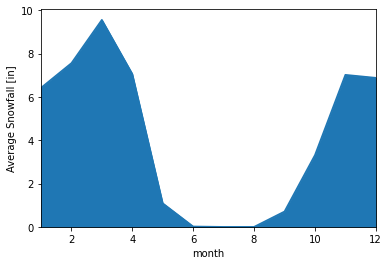

In [57]:
avg_snow.plot.area(ylabel = "Average Snowfall [in]", xlim = (1,12))

#### Replacing **pandas** with **cuDF** for GPU use

For *series* and *DataFrames*, **cuDF** allows us to leverage GPUs for computation. Note that unlike **CuPy**, the **cuDF** package is part of RAPIDS and developed by NVIDIA. Thus it will NOT work on other hardware at this time.

Many **pandas** methods and functions and have been replicated with **cuDF**, allowing for near drop-in replacement.

In [58]:
import cudf as cd

In [59]:
%%time
gpu_df = cd.read_csv('data/daily.txt', delim_whitespace = True,
                     names = ['x'] + col_names).drop(columns = 'x').replace([-998, -999], cd.NA)

CPU times: user 41.4 ms, sys: 13.9 ms, total: 55.3 ms
Wall time: 610 ms


*This doesn't look the same, however!*

It turns out we need to make a few modifications for cuDF to read the data in:
1. cuDF does not ignore a leading space on each row, so we handle this by assigning the column a dummy name and then dropping it after it is read.
2. cuDF will not take integers for the na values, and so we use `.replace` after read-in to get the same effect.

In [60]:
gpu_df.head()

,year,month,day,tmax,tmin,precip,snow,snowcover
0,1897,1,1,<NA>,<NA>,<NA>,<NA>,<NA>
1,1897,1,2,<NA>,<NA>,<NA>,<NA>,<NA>
2,1897,1,3,<NA>,<NA>,<NA>,<NA>,<NA>
3,1897,1,4,<NA>,<NA>,<NA>,<NA>,<NA>
4,1897,1,5,<NA>,<NA>,<NA>,<NA>,<NA>


In [61]:
print(f'Mem used: {gpu_df.memory_usage(deep = True).sum() / 1024**2:.2f} MiB')

Mem used: 2.83 MiB


Here again we must make a small modification to our CPU code - cuDF's groupby operation will not operate on a *column-index* unless it is explicitly told to do so with the `level` parameter. pandas will infer that we mean the index by names, but cuDF better adheres to pandas' own specification!

In [62]:
%%time
gpu_snow = gpu_df[gpu_df.year > 1897].groupby(['year', 'month']).sum().groupby(level = 'month').snow.mean()

CPU times: user 11.5 ms, sys: 2.54 ms, total: 14.1 ms
Wall time: 49.6 ms


<AxesSubplot:xlabel='month', ylabel='Average Snowfall [in]'>

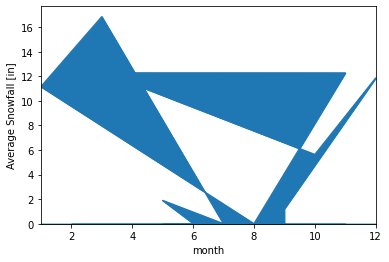

In [63]:
gpu_snow.to_pandas().plot.area(ylabel = "Average Snowfall [in]", xlim = (1,12))

That's an interesting plot. :-) It brings us to another difference between pandas and cuDF - it's groupby operations do not guarantee order as pandas' do. As such, if we want to get the pandas-equivalent result, we can sort the resulting data series by its index:

<AxesSubplot:xlabel='month', ylabel='Average Snowfall [in]'>

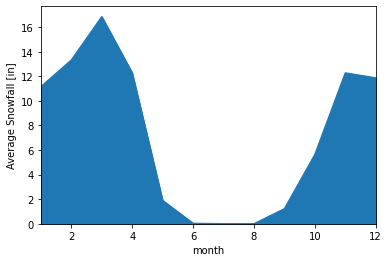

In [64]:
gpu_snow.to_pandas().sort_index().plot.area(ylabel = "Average Snowfall [in]", xlim = (1,12))

In [ ]:
del cpu_df, gpu_df, avg_snow, gpu_snow

#### **cuDF** benefits appear at scale

Last time, we saw that **CuPy** only sped up calculations compared to **Numpy** at a certain problem size. We can show the same phenomenon with *DataFrames*.

Here, we use a big [Earth Surface Temperature dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data) provided at Kaggle from Berkeley Earth.

In [66]:
!ls -lh data/GlobalLandTemperaturesByCity.csv

-rw-rw-r-- 1 vanderwb csgteam 509M Sep 19  2019 data/GlobalLandTemperaturesByCity.csv


In [67]:
cpu_big = pd.read_csv('data/GlobalLandTemperaturesByCity.csv',
                      infer_datetime_format = True, parse_dates = [0])
print(f'Mem used: {cpu_big.memory_usage(deep = True).sum() / 1024**3:.2f} GiB')

Mem used: 2.25 GiB


In [68]:
%%time
gpu_big = cd.DataFrame.from_pandas(cpu_big)

CPU times: user 944 ms, sys: 49.3 ms, total: 994 ms
Wall time: 988 ms


**Compute global mean August temperature timeseries using the CPU and GPU ...**

In [69]:
%%time
global_mean = cpu_big[(cpu_big.dt.dt.month == 8) &
                      (cpu_big.dt.dt.year >= 1900)].groupby('dt')['AverageTemperature'].mean()

CPU times: user 1.25 s, sys: 46.9 ms, total: 1.29 s
Wall time: 1.26 s


In [70]:
%%time
global_mean = gpu_big[(gpu_big.dt.dt.month == 8) &
                      (gpu_big.dt.dt.year >= 1900)].groupby('dt')['AverageTemperature'].mean()

CPU times: user 8.34 ms, sys: 4.66 ms, total: 13 ms
Wall time: 12 ms


<AxesSubplot:xlabel='dt'>

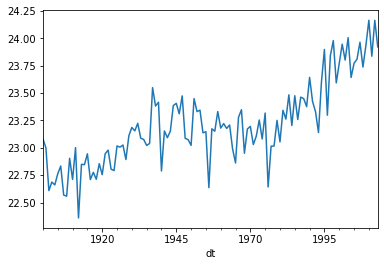

In [71]:
global_mean.to_pandas().sort_index().plot()

In [72]:
del cpu_big, gpu_big, global_mean

#### **cuDF-pandas** compatibility

Some notable differences ([more here](https://docs.rapids.ai/api/cudf/stable/user_guide/pandas-comparison.html)) between cuDF and Pandas:
* `.join` and `.groupby` operations do not guarantee the row order of the output with **cuDF**
* Iteration over **cuDF** objects is not allowed, as GPUs are not efficient for sequential tasks
* Storing arbitrary Python objects (e.g., a column with strings and lists) is not allowed in **cuDF**

---

### Xarray - N-dimensional labeled arrays

Xarray can organize layered annotated sets of array data into data structures that enable complex operations on these N-dimensional datasets. It couples tightly with netCDF/Zarr data and Dask and is very popular at NCAR. As demonstrated last week, it is possible to use CuPy arrays as the underlying data structure in Xarray, enabling offload to GPUs. Efforts to improve compatibility and usability are ongoing - reports of any issues or needed functionalities are desired by the maintainers! (see [this GitHub repo](https://github.com/xarray-contrib/cupy-xarray))

---

## Dask Resources

[Dask Online Tutorial](https://tutorial.dask.org/)

[Dask Distributed Documentation](https://distributed.dask.org/en/stable/)

[dask-jobqueue Documentation](https://jobqueue.dask.org/en/latest/)

[dask-cuda Documentation](https://docs.rapids.ai/api/dask-cuda/stable/)

[How to: Use Dask with GPUs](https://docs.dask.org/en/stable/gpu.html)

[dask-mpi and GPUs](http://mpi.dask.org/en/latest/gpu.html)

[Dask on GPUs Speedups](https://blog.dask.org/2019/01/03/dask-array-gpus-first-steps)

---


## High-level Collections Resources

[CuPy Documentation](https://docs.cupy.dev/en/stable/index.html)

[cuDF Documentation](https://docs.rapids.ai/api/cudf/stable/)

[cupy-xarray Quickstart](https://cupy-xarray.readthedocs.io/quickstart.html)

---

## Running this notebook yourself
### Notebook Setup

This notebook will require running within a JupyterHub PBS Batch (interactive) session.  Much of the Python code will fail if a GPU is not detected on the node.  Select the PBS Batch option when launching from JupyterHub and set the `PROJECT` code to a currently active project, ie `UCIS0004` for the GPU workshop, and `QUEUE` to the appropriate routing queue depending on if during weekday 8am to 5:30pm MT (`gpudev`), or all other times (`casper`). Request `30` GB of memory for this session. Due to limited shared GPU resources, please use `GPU_TYPE=gp100` during the workshop. Otherwise, set `GPU_TYPE=v100` (required for `gpudev`) for independent work. See [Casper queue documentation](https://arc.ucar.edu/knowledge_base/72581396#StartingCasperjobswithPBS-Concurrentresourcelimits) for more info.

If running this notebook outside of the NCAR computing environment, at least one compatible NVIDIA GPU is required to run most of the local cuDF and Dask examples - and access to a batch cluster with GPUs is required for the Dask Distributed examples.

### Changing Notebook Kernel

You'll need to use a JupyterHub kernel that features the RAPIDS suite of packages (at least `CuPy`, `cuDF`, and various `Dask` packages).  There are several ways to do this but you can navigate to the `Kernel` dropdown and select `Change Kernel`.  Select **GPU Workshop** kernel from the dropdown to run the CuPy examples in this notebook.

### Python Virtual Environment Setup

You can set up your own virtual environment for running the Python code outside of this notebook.  This will also be useful if you would like to create your own virtual environment for GPU programming experimentation with Python.

See [Python Conda environment documentation](https://kb.ucar.edu/display/RC/Using+conda+environments+for+Python+access) for background on using Conda on NCAR clusters. Use conda (or mamba for faster package solving) to create your own GPU-enabled environment. Here are the steps for doing so on Casper:

```bash
# Conda used for virtual environment in NCAR clusters
module load conda/latest

# Create the environment and the populate it with packages
# Note that we need channel priority flexible for RAPIDS to install
conda create -n pygpu-dask
conda activate pygpu-dask
conda config --env --set channel_priority flexible
conda env update --file envs/environment.yml

# Don't forget to deactivate with "conda deactivate"

```

If running on other systems, you should install Jupyter as well so that you may use notebooks.